## Transfer Learning: VGG Model

**Dataset used: Ants & Bees Dataset** (freely available on Kaggle)

Implementation by: Om Prabhu (19D170018)

We try to distinguish and and bees with the help of a CNN model using the VGG (Visual Geometry Group) architecture.

In [14]:
# importing data libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
import warnings
warnings.filterwarnings('ignore')

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
!git clone https://github.com/jaddoescad/ants_and_bees.git
!ls ants_and_bees/train

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


ants
bees


In [17]:
batch_size = 20

transformation_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear = 10, scale = (0.8,1.2)),
    transforms.ColorJitter(brightness = 1, contrast = 1, saturation = 1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
 
transformation_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# import dataset
train_dataset = datasets.ImageFolder(root = 'ants_and_bees/train', transform = transformation_train)
test_dataset  = datasets.ImageFolder(root = 'ants_and_bees/val', transform = transformation_test)
classes = ['ant', 'bee'] 

# construct data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [18]:
train_iterator = iter(train_loader)
train_images, train_labels = next(train_iterator)
print(train_images.shape)
print(train_labels.shape)

torch.Size([20, 3, 224, 224])
torch.Size([20])


In [19]:
# plot an image
def convert_img(tensor_image):
    np_image = tensor_image.clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalise image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

def convert_img_cuda(tensor_image):
    np_image = tensor_image.cpu().clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalise image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

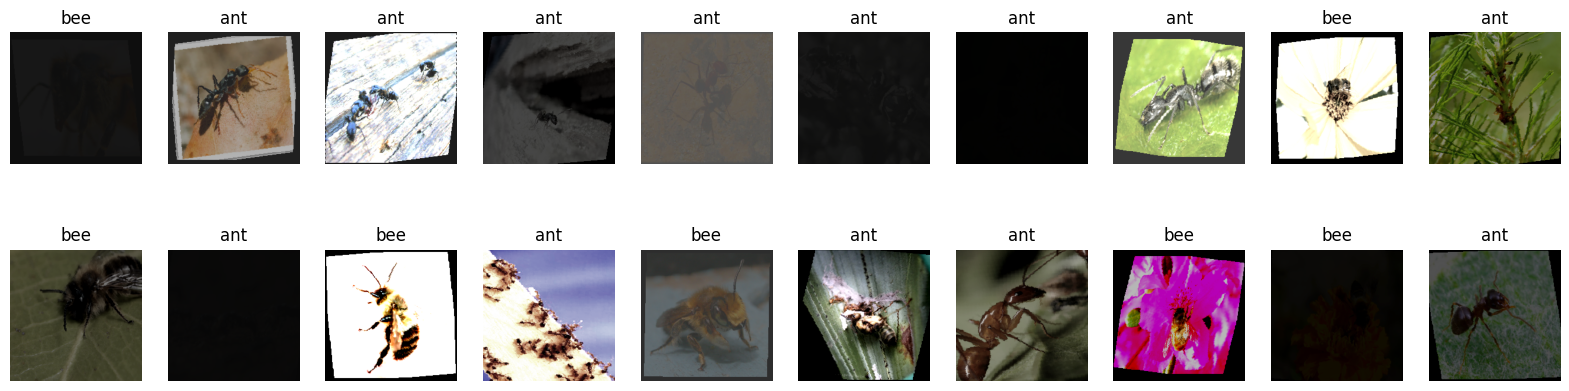

In [20]:
figure = plt.figure(figsize = (20,8))    

for i in range(batch_size):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img(train_images[i])
    title = classes[train_labels[i]]
    plt.imshow(image) 
    plt.title(title)
    plt.axis('off')

plt.show()

In [21]:
vgg_model = models.vgg16(pretrained=True)
print(vgg_model)

RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 411041792 bytes.

In [22]:
for feature_extraction_layer in vgg_model.features.parameters():
    feature_extraction_layer.requires_grad = False

last_layer_inputs = vgg_model.classifier[6].in_features
last_layer = nn.Linear(last_layer_inputs, len(classes))
vgg_model.classifier[6] = last_layer
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(vgg_model.parameters(), lr = 0.0001)

In [11]:
numEpochs = 10
train_count = len(train_loader) * batch_size
test_count = len(test_loader) * batch_size
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# training with the number of epochs.
for epoch in range(numEpochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
  
    # training the model with the train dataset.
    for train_images, train_labels in train_loader:
    
        # registering train images and labels 
        # to device to benefit from GPU
        train_images = train_images.to( device )
        train_labels = train_labels.to( device )
    
        # calculate loss for training dataset for the current batch.
        train_labels_head = vgg_model.forward(train_images)
        loss = criterion(train_labels_head, train_labels)
    
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
        # calculate accuracy for the currentbatch for the training dataset.
        predictions = torch.max(train_labels_head, 1)[1] 
        accuracy = torch.sum(predictions == train_labels)
    
        # sum training accuracy and loss with remaining batches
        train_acc += accuracy 
        train_loss += loss.item()
    
    print("EPOCH --> " + str(epoch + 1))
    print("----------------------------------------------")
  
    # test the current model within the current epoch
    for test_images, test_labels in test_loader:
    
        # register test images and labels to device to benefit from GPU
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
    
        # calculate loss for test dataset for current batch
        test_labels_head = vgg_model.forward(test_images)
        loss = criterion(test_labels_head, test_labels)
    
        # calculate accuracy for the current batch for the test dataset
        predictions = torch.max(test_labels_head, 1)[1] 
        acurracy = torch.sum(predictions == test_labels)
    
        # sum test accuracy and loss with the remaining batches
        test_acc += acurracy 
        test_loss += loss.item()
 
    # print out the training dataset results for current batch
    train_acc = float(train_acc.float()) / train_count
    train_accuracies.append(train_acc)
    print("Train Accuracy: " + str( float(train_acc)))
    
    train_loss = train_loss / train_count
    train_losses.append(train_loss)
    print("Train Loss: " + str(train_loss) + "\n")
  
    # print out the test dataset results for the current batch
    test_acc = float(test_acc.float()) / test_count
    test_accuracies.append(test_acc)
    print("Test Accuracy: " + str( float(test_acc)))    
    
    test_loss = test_loss / test_count
    test_losses.append(test_loss)
    print("Test Loss: " + str(test_loss))
    print("----------------------------------------------\n")

EPOCH --> 1
----------------------------------------------
Train Accuracy: 0.5769230769230769
Train Loss: 0.03555898001560798

Test Accuracy: 0.8625
Test Loss: 0.014455792540684343
----------------------------------------------

EPOCH --> 2
----------------------------------------------
Train Accuracy: 0.7576923076923077
Train Loss: 0.018822319977558576

Test Accuracy: 0.8625
Test Loss: 0.014087209245190024
----------------------------------------------

EPOCH --> 3
----------------------------------------------
Train Accuracy: 0.7884615384615384
Train Loss: 0.018844963037050688

Test Accuracy: 0.83125
Test Loss: 0.019563067983835936
----------------------------------------------

EPOCH --> 4
----------------------------------------------
Train Accuracy: 0.7807692307692308
Train Loss: 0.01595517875483403

Test Accuracy: 0.86875
Test Loss: 0.015132153034210205
----------------------------------------------

EPOCH --> 5
----------------------------------------------
Train Accuracy: 0.815

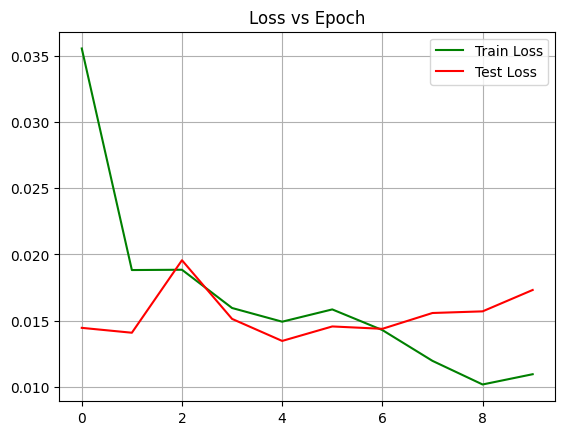

In [12]:
# plotting loss graph.
plt.title("Loss vs Epoch")
plt.plot(train_losses, label = "Train Loss", color= "green")
plt.plot(test_losses, label = "Test Loss", color= "red")
plt.legend()
plt.grid()

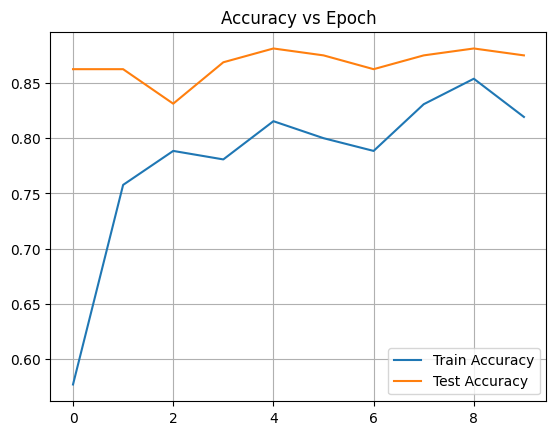

In [13]:
plt.title("Accuracy vs Epoch")
plt.plot(train_accuracies, label = "Train Accuracy")
plt.plot(test_accuracies, label = "Test Accuracy")
plt.legend()
plt.grid()

In [14]:
test_iterator = iter(test_loader)
test_images, test_labels = next(test_iterator)
test_labels = test_labels.to(device)
test_images = test_images.to(device)
test_predict = vgg_model.forward(test_images)
test_predict = torch.max(test_predict, 1)[1] 
print(test_images.shape)
print(test_labels.shape)
print(test_predict.shape)

torch.Size([20, 3, 224, 224])
torch.Size([20])
torch.Size([20])


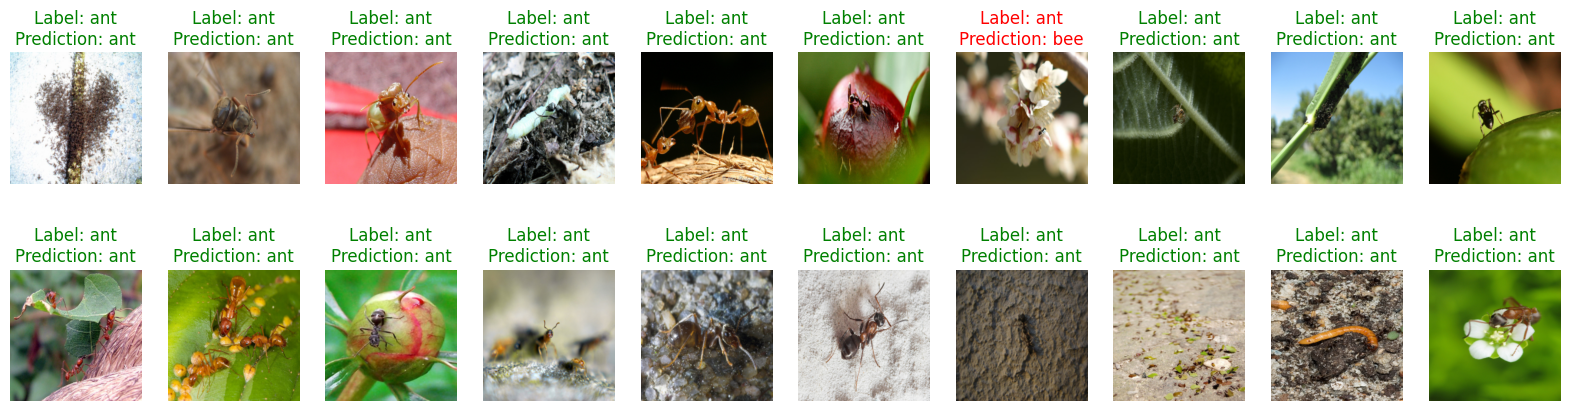

In [15]:
figure = plt.figure(figsize=(20,8))    

for i in range(batch_size):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img_cuda(test_images[i])
    title = "Label: " + str(classes[test_labels[i]]) + "\n" + "Prediction: " + str(classes[test_predict[i]]) 

    plt.imshow(image) 
    plt.axis('off')

    if(str( classes[test_labels[i]]) == str(classes[test_predict[i]])):
        plt.title(title, color="green")
    else:
        plt.title(title, color="red")

plt.show()

In [16]:
accuracy = torch.sum(test_predict == test_labels)
print("Test Accuracy:", float(accuracy) / batch_size)

Test Accuracy: 0.95
